In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [3]:
import matplotlib.pyplot as plt

import load_dataset
import plotting

In [4]:
dataset = load_dataset.Dataset('../data/dataset/')

## Разбор (не запускать ячейки)

### Выгрузим временной ряд индекса Доу-Джонса, один из ярких примеров рядов, который, будучи случайным блужданием, очень сложно предсказать лучше наивного метода.

In [5]:
ts = dataset['dow_jones_3.csv']

<AxesSubplot:xlabel='2018-11-30'>

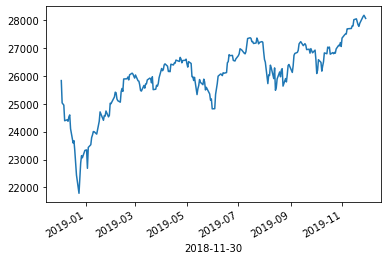

In [6]:
ts.plot()

In [7]:
len(ts)

250

### Разобьем ряд на трейн и тест и попробуем зафитить нашу "сложную" ML модель TimeSeriesPredictor с базой в виде линейной регрессии.

In [8]:
ts_train, ts_test = ts[:200], ts[200:]

In [9]:
from model import TimeSeriesPredictor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

predictor = TimeSeriesPredictor(
    num_lags=12,
    granularity='P1D',
    model=LinearRegression
)

In [10]:
predictor.fit(ts_train)

### Сделаем one step ahead предсказания на тесте, предсказание выглядит неплохо.

In [11]:
preds = predictor.predict_batch(ts_train, ts_test)

<AxesSubplot:xlabel='2018-11-30'>

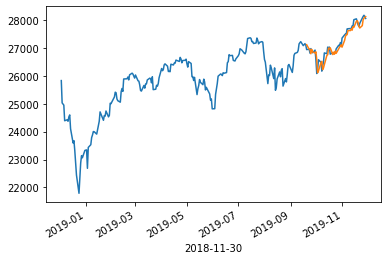

In [12]:
# кажется, получилось весьма неплохо
ts.plot()
preds.plot()

### Давайте посмотрим на абсолютные метрики.

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [14]:
mean_squared_error(preds, ts_test)

32553.10051427126

In [15]:
mean_absolute_error(preds, ts_test)

137.9848002737418

In [24]:
# выдать какой-то вердикт по ним, впрочем, сложно

### Остатки тоже выглядят неплохо

<AxesSubplot:xlabel='2018-11-30'>

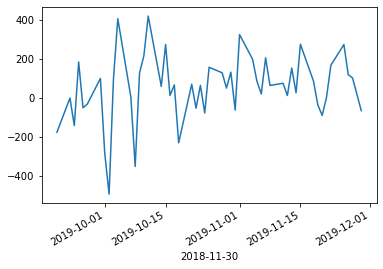

In [16]:
(ts_test-preds).plot()

### Дикки-Фуллер говорит о стационарности остатков.

In [17]:
from statsmodels.tsa.stattools import adfuller
adfuller(ts_test-preds)[1]

0.035026145165844895

### По всем признакам, мы получили неплохую модель. Пора выкатывать на прод!

### А теперь давайте сравним с наивным предсказанием.

In [30]:
from metrics import mase

In [31]:
mase(preds, ts_test, method='naive')

1.1007868702939125

### Модель показывает себя на 10% хуже наивного предсказания! 

![img](../data/images/directed.jpg)

## Задание

Реализуйте метрику MASE, которая записывается, как  
`mase = MAE(y_pred, y_true) / MAE(y_reference, y_true)`, где  
`y_pred` - one step ahead предсказания вашей модели на некой тестовой выборке  
`y_true` - реальные значения тестовой выборки  
`y_reference` - предсказания сравниваемой модели на той же тестовой выборке  


* чтобы получить y_reference для наивного метода, достаточно только сдвинуть y_true (потерей одной точки в данном задании перенебрегаем
* чтобы получить y_reference для всех остальных методов, необходимо передать в функцию историю ряда до y_true.
* реализацию методов mean, median можете сделать как на всем ts, так и на произвольном скользящем окне по вашему усмотрению

In [24]:
from sklearn.metrics import mean_absolute_error as mae

In [53]:
def mase(y_pred, y_true, method='naive', ts=None):
    """
    Реализуйте метрику mase для сравнения предсказаний y_pred вашего метода и y_method, являющегося
    предсказанием метода, указанного в параметре method.
    
    Формула для расчета mase = MAE(y_pred, y_true) / MAE(y_reference, y_true), 
    где MAE - mean absolute error - средняя абсолютная ошибка.
    
    В качестве method реализуйте поддержку {'naive', 'mean', 'median'}.
    
    Для наивного метода достаточно использовать только y_true.
    Для методов средней и медианы понадобится использовать временной ряд ts.
    
    """
    if method == 'naive':
        y_reference = y_true.shift()
        mase = mae(y_true[1:], y_pred[1:])/ mae(y_true[1:], y_reference[1:])
    
#     if method == 'mean':
        
    
    
    return mase

In [54]:
mase(preds, ts_test, method='naive')

1.1137931655870792